# Parkinson's Disease Prediction

#### Dataset reference : Zham P, Kumar DK, Dabnichki P, Poosapadi Arjunan S and Raghav S (2017) Distinguishing Different Stages of Parkinson’s Disease Using Composite Index of Speed and Pen-Pressure of Sketching a Spiral. Front. Neurol. 8:435. doi: 10.3389/fneur.2017.00435

In [1]:
# Core Libraries and Data Handling
import os  
import random  
import warnings
import numpy as np  
import pandas as pd 
import csv  

# Machine Learning Libraries 
import torch
import torch.nn as nn 
from torchvision import transforms      # Offers image transformation utilities. 
from torch.utils.data import DataLoader, Dataset   # Provides data loading utilities and dataset abstractions.
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier
import joblib       # For saving and loading Python objects.
from PIL import Image      # Library for image processing.

# Modeling and Evaluation Libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, matthews_corrcoef
from transformers import ViTImageProcessor, ViTModel

# Visualization Libraries 
import matplotlib.pyplot as plt
import seaborn as sns 

# Miscellaneous Libraries
import pickle 
from tqdm import tqdm 

# Feature Extraction

In [ ]:
# Define paths to your dataset directories
base_dir = 'C:/Users/DELL/Downloads\Real Life PD detector using KNN and ViT/spiral data'

# Spiral data
spiral_train_dir_healthy = os.path.join(base_dir, 'training/healthy')
spiral_train_dir_parkinson = os.path.join(base_dir, 'training/parkinson')
spiral_test_dir_healthy = os.path.join(base_dir, 'testing/healthy')
spiral_test_dir_parkinson = os.path.join(base_dir, 'testing/parkinson')

In [ ]:
# Function to check directory contents
def check_directory_contents(directory):
    print(f"Checking directory: {directory}")
    for root, dirs, files in os.walk(directory):
        print(f"Found {len(files)} files in {root}")
        for file in files[:5]:  # Display only first 5 files for brevity
            print(file)
        break  # Only check the top directory level

# Check all directories
check_directory_contents(spiral_train_dir_healthy)
check_directory_contents(spiral_train_dir_parkinson)
check_directory_contents(spiral_test_dir_healthy)
check_directory_contents(spiral_test_dir_parkinson)

Checking directory: C:/Users/DELL/Downloads\Real Life PD detector using KNN and ViT/spiral data\training/healthy
Found 36 files in C:/Users/DELL/Downloads\Real Life PD detector using KNN and ViT/spiral data\training/healthy
V01HE02.png
V01HE03.png
V02HE02.png
V02HE03.png
V03HE2.png
Checking directory: C:/Users/DELL/Downloads\Real Life PD detector using KNN and ViT/spiral data\training/parkinson
Found 36 files in C:/Users/DELL/Downloads\Real Life PD detector using KNN and ViT/spiral data\training/parkinson
V01PE02.png
V01PE03.png
V02PE02.png
V02PE03.png
V03PE02.png
Checking directory: C:/Users/DELL/Downloads\Real Life PD detector using KNN and ViT/spiral data\testing/healthy
Found 15 files in C:/Users/DELL/Downloads\Real Life PD detector using KNN and ViT/spiral data\testing/healthy
V01HE01.png
V02HE01.png
V03HE1.png
V04HE01.png
V05HE01.png
Checking directory: C:/Users/DELL/Downloads\Real Life PD detector using KNN and ViT/spiral data\testing/parkinson
Found 15 files in C:/Users/DELL/Do

# Vizualisations

In [ ]:
# Function to visualize images
def visualize_images(image_dir, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, filename in enumerate(os.listdir(image_dir)[:num_images]):
        img = plt.imread(os.path.join(image_dir, filename))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

Spiral test healthy


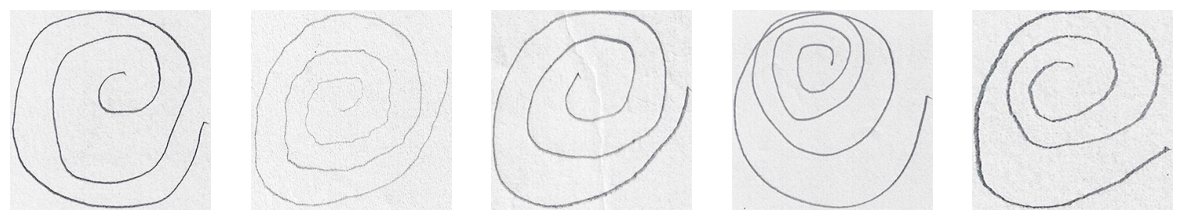

In [ ]:
# Visualize examples from each category
print("Spiral test healthy")
visualize_images(spiral_test_dir_healthy)

Spiral test parkinson


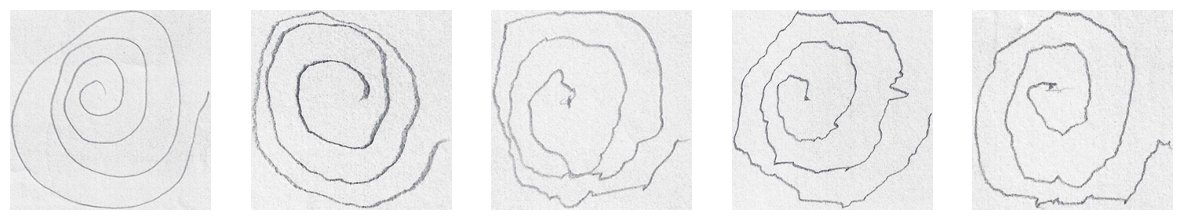

In [ ]:
print("Spiral test parkinson")
visualize_images(spiral_test_dir_parkinson)

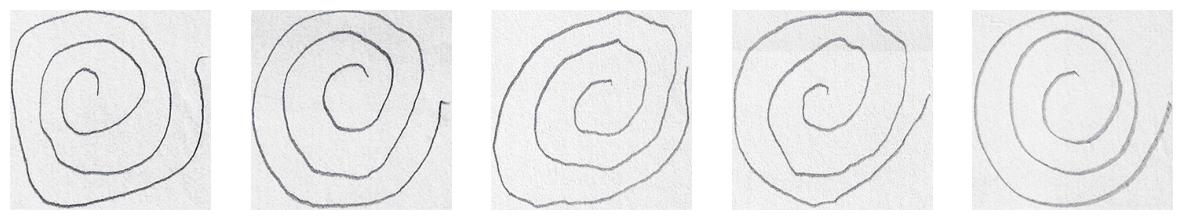

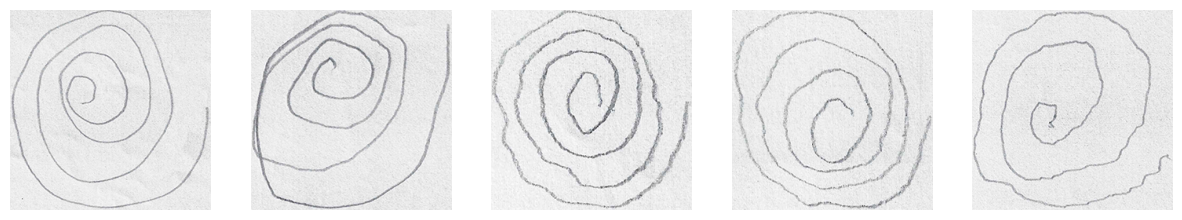

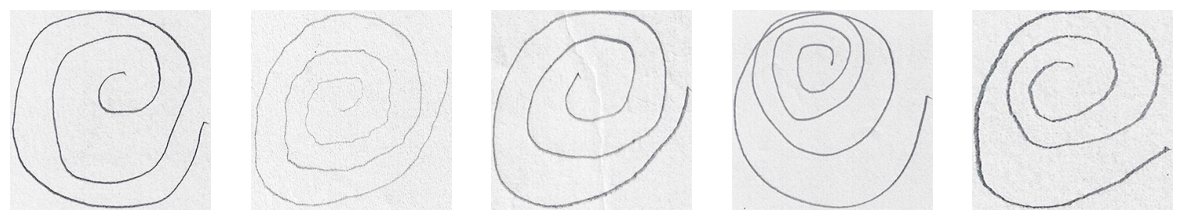

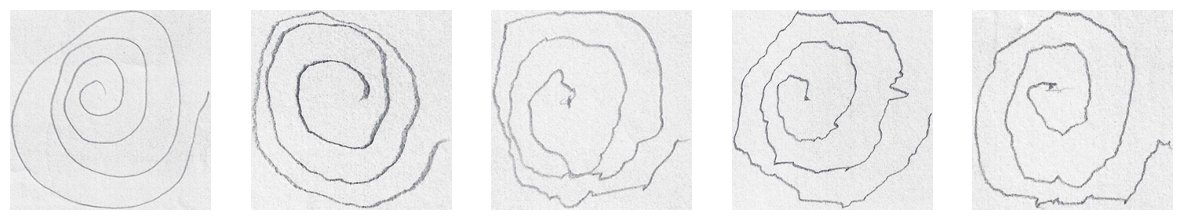

In [ ]:

# Function to visualize images
def visualize_images(image_dir, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, filename in enumerate(os.listdir(image_dir)[:num_images]):
        img = plt.imread(os.path.join(image_dir, filename))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Visualize images from each directory
visualize_images(spiral_train_dir_healthy, num_images=5)
visualize_images(spiral_train_dir_parkinson, num_images=5)
visualize_images(spiral_test_dir_healthy, num_images=5)
visualize_images(spiral_test_dir_parkinson, num_images=5)

# 1. Integration of ViT with KNN

## Logging Setup

In [ ]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Seed Setting
##### Sets the seed for random number generators in Python, NumPy, and PyTorch to ensure reproducibility of results.

In [ ]:
def set_seed(seed=42):
    """Set the random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

##### Ensures that each worker in the DataLoader has a different seed, which helps in maintaining reproducibility across parallel data loading.

In [ ]:
def worker_init_fn(worker_id):
    """Worker init function to set seed for each worker in data loading"""
    np.random.seed(42 + worker_id)

# Custom Dataset Class
##### ParkinsonDataset: Custom dataset class to load images and labels.

In [ ]:
class ParkinsonDataset(Dataset):
    """Custom dataset class for handling PD image data"""
    def __init__(self, image_dirs, transform=None):
        self.image_paths = []
        self.labels = []
        for image_dir, label in image_dirs:
            for img in os.listdir(image_dir):
                img_path = os.path.join(image_dir, img)
                if os.path.isfile(img_path):
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        self.transform = transform
        self.processor = ViTImageProcessor(do_rescale=False)  # Use ViTImageProcessor for preprocessing

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        inputs = self.processor(images=image, return_tensors="pt")
        return inputs['pixel_values'].squeeze(0), torch.tensor(label)

# Image Transformations
##### Defines a series of transformations to apply to images: resizing to 224x224 pixels and converting to a tensor.

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensor
])

# Feature Extraction Model
##### FeatureExtractor: Uses a pre-trained Vision Transformer (ViT) model to extract features from images.

In [ ]:
class FeatureExtractor(nn.Module):
    """Feature extractor using Vision Transformer (ViT)."""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.feature_extractor = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

    def forward(self, x):
        with torch.no_grad():
            outputs = self.feature_extractor(x)
            features = outputs.last_hidden_state[:, 0]  # Use CLS token as feature vector
        return features

# Feature Extraction Function
##### extract_features: Extracts features from the dataset using the feature extraction model.
* model.eval(): Sets the model to evaluation mode.
* tqdm: Displays a progress bar for feature extraction.
* Collects features and labels, then concatenates and returns them.

In [ ]:
def extract_features(model, data_loader, device):
    """Extract features from images using the feature extractor model."""
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, label in tqdm(data_loader, desc="Extracting features"):
            inputs = inputs.to(device)
            feature = model(inputs)
            features.append(feature.cpu().numpy())
            labels.extend(label.numpy())
    return np.concatenate(features), np.array(labels)

# Accuracy Calculation
##### calculate_accuracy: Computes the accuracy score of predictions against true labels.

In [ ]:
def calculate_accuracy(predictions, true_labels):
    """Calculate and return the accuracy"""
    return accuracy_score(true_labels, predictions)

# Cross-Validation Results Printing
##### print_cv_results: Prints the mean accuracy and standard deviation for each hyperparameter combination in GridSearchCV.

In [ ]:
def print_cv_results(cv_results):
    """Print cross-validation results from GridSearchCV"""
    means = cv_results['mean_test_score']
    stds = cv_results['std_test_score']
    params = cv_results['params']
    for mean, std, param in zip(means, stds, params):
        print(f"Mean Accuracy: {mean:.4f} (+/- {std:.4f}) for {param}")

Prints cross-validation results from GridSearchCV

In [ ]:
def print_cross_validation_results(grid_search):
    """Print cross-validation results from GridSearchCV."""
    results = grid_search.cv_results_
    for mean_score, std_score, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
        print(f"Mean Accuracy: {mean_score:.4f} (+/- {std_score:.4f}) for {params}")

# Plotting Functions
##### plot_cv_results: Plots mean accuracy and standard deviation from cross-validation results for different KNN hyperparameters.

In [ ]:
def plot_cv_results(grid_search):
    """Plot cross-validation results for KNN hyperparameters"""
    results = grid_search.cv_results_
    mean_scores = results['mean_test_score']
    std_scores = results['std_test_score']
    params = results['params']

    # Extract the parameters
    neighbors = [param['n_neighbors'] for param in params]
    p_values = [param['p'] for param in params]
    weights = [param['weights'] for param in params]

    # Create a figure for plotting
    plt.figure(figsize=(12, 6))

    # Plot mean accuracy with standard deviation
    plt.errorbar(neighbors, mean_scores, yerr=std_scores, fmt='o', capsize=5)
    plt.title('Cross-Validation Mean Accuracy with Standard Deviation')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Mean Accuracy')
    plt.grid(True)

    # Save or show the plot
    plt.tight_layout()
    plt.show()

##### Plots the ROC curve

In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc):
    """Plot ROC curve"""
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


##### Plots the Precision-Recall curve, showing the trade-off between precision and recall.

In [ ]:
def plot_precision_recall_curve(precision, recall, pr_auc):
    """Plot Precision-Recall curve"""
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

##### Plots the confusion matrix as a heatmap using Seaborn for better visualization.

In [ ]:
def plot_confusion_matrix(cm, labels):
    """Plot confusion matrix as a heatmap"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Model Evaluation
##### evaluate_model: Evaluates the model using various metrics:
* Confusion Matrix: Shows the counts of true positives, true negatives, false positives, and false negatives.
* ROC Curve: Evaluates the model's performance across different thresholds.
* Precision-Recall Curve: Assesses the precision and recall trade-off.
* Matthews Correlation Coefficient (MCC): Provides a balanced measure of classification performance.

In [ ]:
def evaluate_model(true_labels, predictions, prob_predictions):
    """Evaluate the model with various metrics"""
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, labels=['Healthy', 'Parkinson']) # Our labels
    
    # AUC-ROC
    fpr, tpr, _ = roc_curve(true_labels, prob_predictions)
    roc_auc = auc(fpr, tpr)
    print(f'AUC-ROC: {roc_auc:.4f}')
    plot_roc_curve(fpr, tpr, roc_auc)
    
    # AUC-PR
    precision, recall, _ = precision_recall_curve(true_labels, prob_predictions)
    pr_auc = average_precision_score(true_labels, prob_predictions)
    print(f'AUC-PR: {pr_auc:.4f}')
    plot_precision_recall_curve(precision, recall, pr_auc)
    
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(true_labels, predictions)
    print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

# Main Function

In [ ]:
# I faced a problem with the code and this was the solution :
# Go to PowerShell and run : echo %CUBLAS_WORKSPACE_CONFIG%
# Then run this : set CUBLAS_WORKSPACE_CONFIG=:4096:8
# Then, restart the IDE (Sometimes environment changes might not take effect until I restart my IDE.)
# Retrieve and print the value of the environment variable 'CUBLAS_WORKSPACE_CONFIG'.
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

2024-09-05 01:19:17,115 - INFO - Using device: cuda:0
2024-09-05 01:19:21,498 - INFO - Extracting training features...
Extracting features: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
2024-09-05 01:19:25,725 - INFO - Extracting testing features...
Extracting features: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]
2024-09-05 01:19:27,395 - INFO - Raw feature dimensions: 768
2024-09-05 01:19:27,395 - INFO - Performing Grid Search for KNN...


Fitting 5 folds for each of 28 candidates, totalling 140 fits
Mean Accuracy: 0.8010 (+/- 0.1394) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Mean Accuracy: 0.8010 (+/- 0.1394) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Mean Accuracy: 0.7724 (+/- 0.1396) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Mean Accuracy: 0.7724 (+/- 0.1396) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Mean Accuracy: 0.7467 (+/- 0.0717) for {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
Mean Accuracy: 0.7743 (+/- 0.1148) for {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Mean Accuracy: 0.7467 (+/- 0.0717) for {'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
Mean Accuracy: 0.8019 (+/- 0.1061) for {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
Mean Accuracy: 0.7876 (+/- 0.1024) for {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Mean Accuracy: 0.7876 (+/- 0.1024) for {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Mean Accuracy: 0.8010 (+/- 0.1154) for {'n_neighbors'

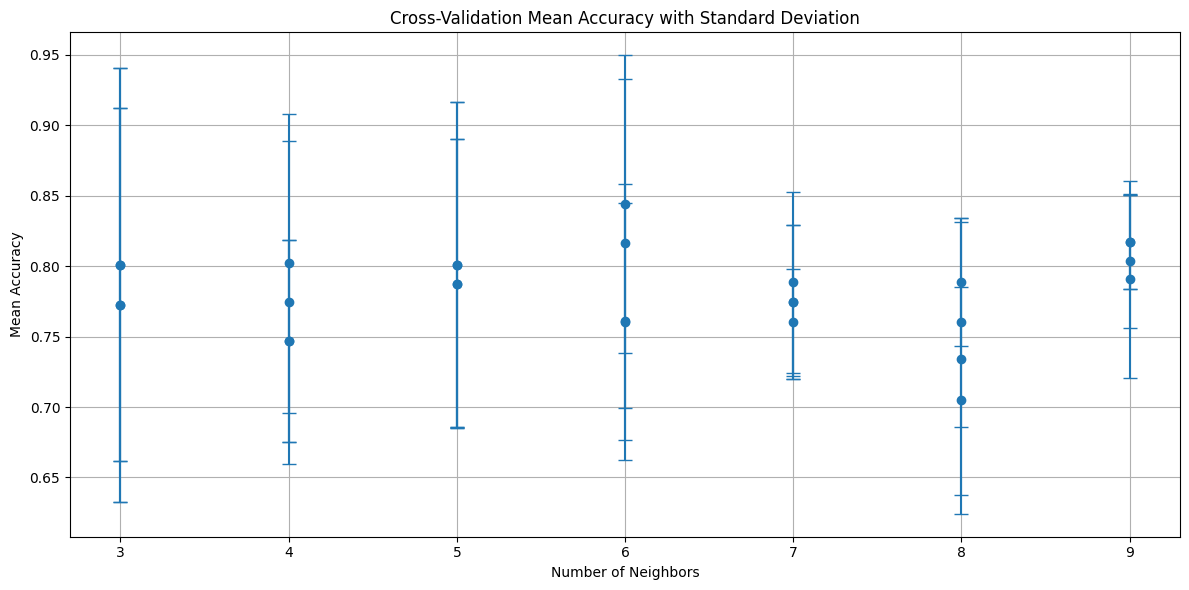

c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
2024-09-05 01:19:29,480 - INFO - Training Accuracy: 100.00%


Test Accuracy: 0.9677
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.93      1.00      0.97        14

    accuracy                           0.97        31
   macro avg       0.97      0.97      0.97        31
weighted avg       0.97      0.97      0.97        31

Confusion Matrix:
[[16  1]
 [ 0 14]]


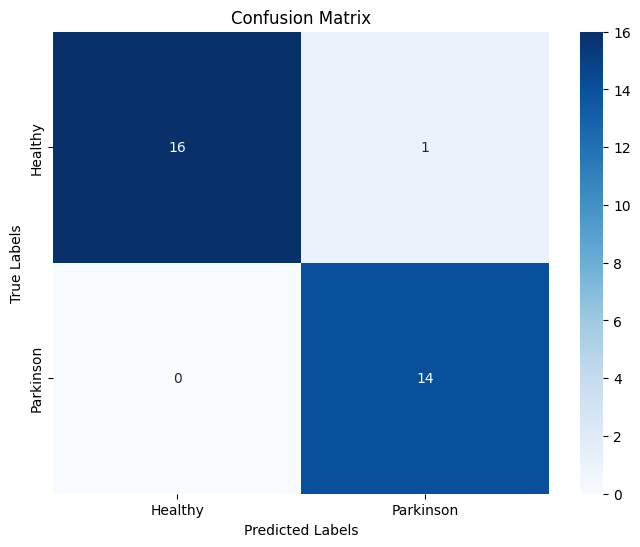

AUC-ROC: 0.9958


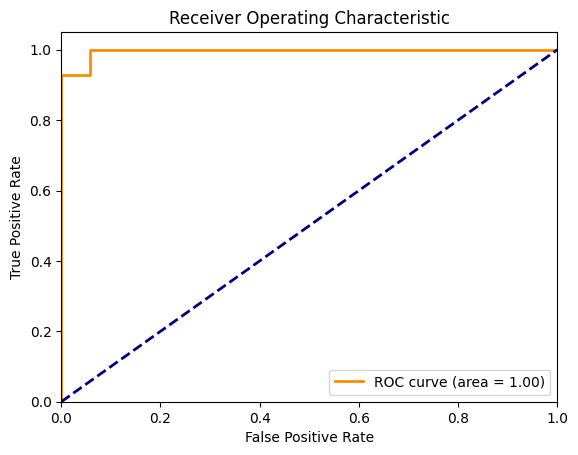

AUC-PR: 0.9952


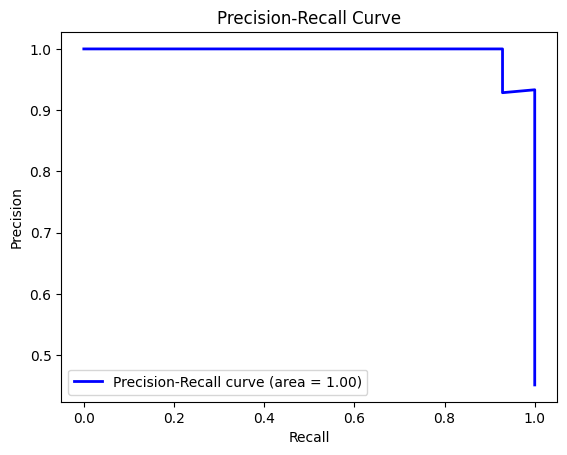

Matthews Correlation Coefficient (MCC): 0.9372


In [ ]:
def main():
    set_seed(42)  # Set the seed for reproducibility
    torch.use_deterministic_algorithms(True)  # Ensure deterministic behavior in PyTorch

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device}")

    model = FeatureExtractor().to(device)
    
    # Dataset Initialization
    # Sets up data loaders for batching and shuffling
    base_dir = 'C:/Users/DELL/Downloads/Second Paper/Real Life PD detector using KNN and ViT/spiral data'
    data_paths = [
        (os.path.join(base_dir, 'training/healthy'), 0),
        (os.path.join(base_dir, 'training/parkinson'), 1),
        (os.path.join(base_dir, 'testing/healthy'), 0),
        (os.path.join(base_dir, 'testing/parkinson'), 1)
    ]

    # Create dataset and split into training and testing
    full_dataset = ParkinsonDataset(data_paths, transform=data_transform)
    train_dataset, test_dataset = train_test_split(full_dataset, test_size=0.3, random_state=42)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
    
    # Feature Extraction
    logging.info("Extracting training features...")
    train_features, train_labels = extract_features(model, train_loader, device)
    logging.info("Extracting testing features...")
    test_features, test_labels = extract_features(model, test_loader, device)

    # Logs the dimensions of the raw feature vectors before classification.
    logging.info(f"Raw feature dimensions: {train_features.shape[1]}")

    # KNN Classifier and Hyperparameter Tuning
    param_grid = {
        'n_neighbors': [3, 4, 5, 6, 7, 8, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # 1 is Manhattan distance, 2 is Euclidean distance
    }

    knn_clf = KNeighborsClassifier()
    grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    logging.info("Performing Grid Search for KNN...")
    grid_search.fit(train_features, train_labels)

    # Prints, plots the cross-validation results and saves the best KNN model using joblib
    print_cross_validation_results(grid_search)
    plot_cv_results(grid_search)

    best_knn_clf = grid_search.best_estimator_
    joblib.dump(best_knn_clf, 'best_knn_model.pkl')

    # Model Evaluation
    test_predictions = best_knn_clf.predict(test_features)
    test_prob_predictions = best_knn_clf.predict_proba(test_features)[:, 1]  # Probabilities for positive class

    # Calculate and print training accuracy
    train_predictions = best_knn_clf.predict(train_features)
    train_accuracy = calculate_accuracy(train_predictions, train_labels)
    logging.info(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Evaluate the model
    accuracy = calculate_accuracy(test_predictions, test_labels)
    print(f"Test Accuracy: {accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(test_labels, test_predictions))

    evaluate_model(test_labels, test_predictions, test_prob_predictions)

if __name__ == "__main__":
    main()

# Case of NO PD

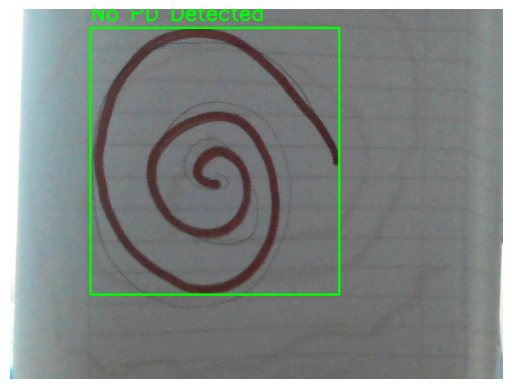

In [29]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torchvision import transforms
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import joblib

# Load the trained KNN model
model_path = 'best_knn_model.pkl'
knn_clf = joblib.load(model_path)

# Feature extraction model setup
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.feature_extractor = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

    def forward(self, x):
        with torch.no_grad():
            outputs = self.feature_extractor(x)
            features = outputs.last_hidden_state[:, 0]  # CLS token
        return features

feature_extractor = FeatureExtractor()
feature_extractor.eval()

# Transformation
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Image processor setup
processor = ViTImageProcessor(do_rescale=False)

def extract_features(image):
    image = Image.fromarray(image).convert('RGB')
    image = data_transform(image)
    image = torch.unsqueeze(image, 0)  # Add batch dimension
    inputs = processor(images=image, return_tensors="pt")
    features = feature_extractor(inputs['pixel_values'])
    return features.detach().numpy()

def predict_pd(frame):
    feature = extract_features(frame)
    prediction = knn_clf.predict(feature)
    return prediction[0]

def preprocess_image(image):
    """Preprocess the image for spiral detection."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        spiral_image = image[y:y+h, x:x+w]
        return spiral_image, (x, y, w, h)
    return None, None

def update_frame(frame):
    spiral_image, rect = preprocess_image(frame)
    
    if spiral_image is not None:
        # Predict PD
        spiral_image_rgb = cv2.cvtColor(spiral_image, cv2.COLOR_BGR2RGB)
        prediction = predict_pd(spiral_image_rgb)
        
        # Draw rectangle around detected spiral
        if rect is not None:
            x, y, w, h = rect
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Display result
            if prediction == 1:
                cv2.putText(frame, "PD Detected: Consult a doctor", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "No PD Detected", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return frame

def main():
    cap = cv2.VideoCapture(0)
    
    fig, ax = plt.subplots()
    img = ax.imshow(np.zeros((480, 640, 3), dtype=np.uint8))
    plt.axis('off')

    def animate(i):
        ret, frame = cap.read()
        if ret:
            frame = update_frame(frame)
            img.set_data(frame)
        return img,

    ani = FuncAnimation(fig, animate, frames=200, interval=50, blit=True)
    plt.show()

    cap.release()

if __name__ == "__main__":
    main()

# Case of PD

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torchvision import transforms
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import joblib

# Load the trained KNN model
model_path = 'best_knn_model.pkl'
knn_clf = joblib.load(model_path)

# Feature extraction model setup
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.feature_extractor = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

    def forward(self, x):
        with torch.no_grad():
            outputs = self.feature_extractor(x)
            features = outputs.last_hidden_state[:, 0]  # CLS token
        return features

feature_extractor = FeatureExtractor()
feature_extractor.eval()

# Transformation
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Image processor setup
processor = ViTImageProcessor(do_rescale=False)

def extract_features(image):
    image = Image.fromarray(image).convert('RGB')
    image = data_transform(image)
    image = torch.unsqueeze(image, 0)  # Add batch dimension
    inputs = processor(images=image, return_tensors="pt")
    features = feature_extractor(inputs['pixel_values'])
    return features.detach().numpy()

def predict_pd(frame):
    feature = extract_features(frame)
    prediction = knn_clf.predict(feature)
    return prediction[0]

def preprocess_image(image):
    """Preprocess the image for spiral detection."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        spiral_image = image[y:y+h, x:x+w]
        return spiral_image, (x, y, w, h)
    return None, None

def update_frame(frame):
    spiral_image, rect = preprocess_image(frame)
    
    if spiral_image is not None:
        # Predict PD
        spiral_image_rgb = cv2.cvtColor(spiral_image, cv2.COLOR_BGR2RGB)
        prediction = predict_pd(spiral_image_rgb)
        
        # Draw rectangle around detected spiral
        if rect is not None:
            x, y, w, h = rect
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Display result
            if prediction == 1:
                cv2.putText(frame, "PD Detected: Consult a doctor", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "No PD Detected", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return frame

def main():
    cap = cv2.VideoCapture(0)
    
    fig, ax = plt.subplots()
    img = ax.imshow(np.zeros((480, 640, 3), dtype=np.uint8))
    plt.axis('off')

    def animate(i):
        ret, frame = cap.read()
        if ret:
            frame = update_frame(frame)
            img.set_data(frame)
        return img,

    ani = FuncAnimation(fig, animate, frames=200, interval=50, blit=True)
    plt.show()

    cap.release()

if __name__ == "__main__":
    main()